# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small.

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible.
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files :
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [1]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip
dir_path = "data/TP4_images/"


In [2]:
!pip install torchmetrics

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchmetrics.classification import BinaryAccuracy, Accuracy, ConfusionMatrix
# you can install torchmetrics with `pip install torchmetrics`

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()

## Question 1 :
>  Change the last layer of the resnet model so that its size fits the problem.

<div class="alert alert-info">  The last Resnet18 is a fully connected layer with an output dimension of 1000 (as the model is meant to be used as a classifier for up to 1000 classes). We change that dimension to 2, as the problem at hand is binary classification. </div>

In [4]:
import torch.nn as nn

# Change to 2 layers the last linear
print(f"Before :")
print(f"base_model.fc : {base_model.fc}")
in_features = base_model.fc.in_features
base_model.fc = nn.Linear(in_features, 2)
print(f"After :")
print(f"base_model.fc : {base_model.fc}")

Before :
base_model.fc : Linear(in_features=512, out_features=1000, bias=True)
After :
base_model.fc : Linear(in_features=512, out_features=2, bias=True)


In [5]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

## Question 2:
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy.

Epoch 1/20, Loss: 0.9096, Accuracy: 0.2619
Epoch 2/20, Loss: 0.6802, Accuracy: 0.5238
Epoch 3/20, Loss: 0.5965, Accuracy: 0.7381
Epoch 4/20, Loss: 0.6027, Accuracy: 0.7381
Epoch 5/20, Loss: 0.6244, Accuracy: 0.7381
Epoch 6/20, Loss: 0.6468, Accuracy: 0.7381
Epoch 7/20, Loss: 0.6517, Accuracy: 0.7381
Epoch 8/20, Loss: 0.6376, Accuracy: 0.7381
Epoch 9/20, Loss: 0.6212, Accuracy: 0.7381
Epoch 10/20, Loss: 0.6088, Accuracy: 0.7381
Epoch 11/20, Loss: 0.5901, Accuracy: 0.7381
Epoch 12/20, Loss: 0.5911, Accuracy: 0.7381
Epoch 13/20, Loss: 0.5877, Accuracy: 0.7381
Epoch 14/20, Loss: 0.5884, Accuracy: 0.7381
Epoch 15/20, Loss: 0.5893, Accuracy: 0.7381
Epoch 16/20, Loss: 0.5921, Accuracy: 0.7381
Epoch 17/20, Loss: 0.5962, Accuracy: 0.7381
Epoch 18/20, Loss: 0.5969, Accuracy: 0.7381
Epoch 19/20, Loss: 0.5925, Accuracy: 0.7381
Epoch 20/20, Loss: 0.5889, Accuracy: 0.7381


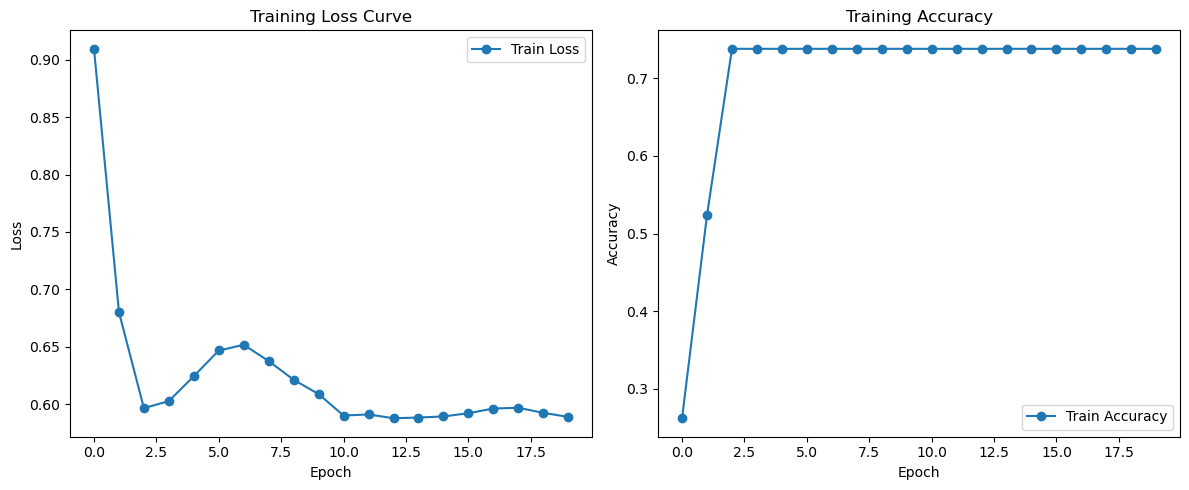

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import models
from utils import precompute_features, LastLayer  # Import your functions and modules

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(weights=None)  # randomly initialized
resnet.fc = nn.Identity()
resnet.to(device)

precomputed_dataset = precompute_features(resnet, north_dataset, device)

# Create a DataLoader for the new dataset
train_loader = DataLoader(precomputed_dataset, batch_size=32, shuffle=True)

# 2. Create the last layer model that takes the precomputed features as input.
last_layer = LastLayer().to(device)

# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(last_layer.parameters(), lr=1e-3) #adjust the lr maybe

# 4. Training loop
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    last_layer.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = last_layer(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# 5. Plot the training curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, marker='o', label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<div class="alert alert-info"> In this example, we first replace the final fully connected layer of the randomly initialized ResNet18 with an identity layer so that we can precompute the intermediate features using the provided <code>precompute_features</code> function. Then we train a separate <code>LastLayer</code> model on these features using cross-entropy loss. The training loop runs for 20 epochs, and we record and plot the loss and accuracy after each epoch.
Because the ResNet feature extractor is randomly initialized, the precomputed features are not very meaningful. As a result, you may observe that the accuracy stays the same throughout the procedure here 0.73 even though the training loss decreases. This highlights the importance of using a pretrained feature extractor for better performance.
</div>

## Question 3 :
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve.

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ ( we will check the size)

 We will test your model on final accuracy on a test set.


Epoch 1/20, Loss: 0.8237, Accuracy: 0.3333
Epoch 2/20, Loss: 0.5870, Accuracy: 0.7143
Epoch 3/20, Loss: 0.5850, Accuracy: 0.7381
Epoch 4/20, Loss: 0.5723, Accuracy: 0.7381
Epoch 5/20, Loss: 0.5185, Accuracy: 0.7381
Epoch 6/20, Loss: 0.4632, Accuracy: 0.7381
Epoch 7/20, Loss: 0.4378, Accuracy: 0.7381
Epoch 8/20, Loss: 0.4029, Accuracy: 0.8571
Epoch 9/20, Loss: 0.3999, Accuracy: 0.9286
Epoch 10/20, Loss: 0.3542, Accuracy: 0.9286
Epoch 11/20, Loss: 0.3211, Accuracy: 0.8810
Epoch 12/20, Loss: 0.3162, Accuracy: 0.8810
Epoch 13/20, Loss: 0.2950, Accuracy: 0.8571
Epoch 14/20, Loss: 0.2984, Accuracy: 0.8810
Epoch 15/20, Loss: 0.2446, Accuracy: 0.9286
Epoch 16/20, Loss: 0.2489, Accuracy: 0.9762
Epoch 17/20, Loss: 0.2440, Accuracy: 0.9762
Epoch 18/20, Loss: 0.2388, Accuracy: 0.9524
Epoch 19/20, Loss: 0.2028, Accuracy: 0.9762
Epoch 20/20, Loss: 0.2082, Accuracy: 0.9524


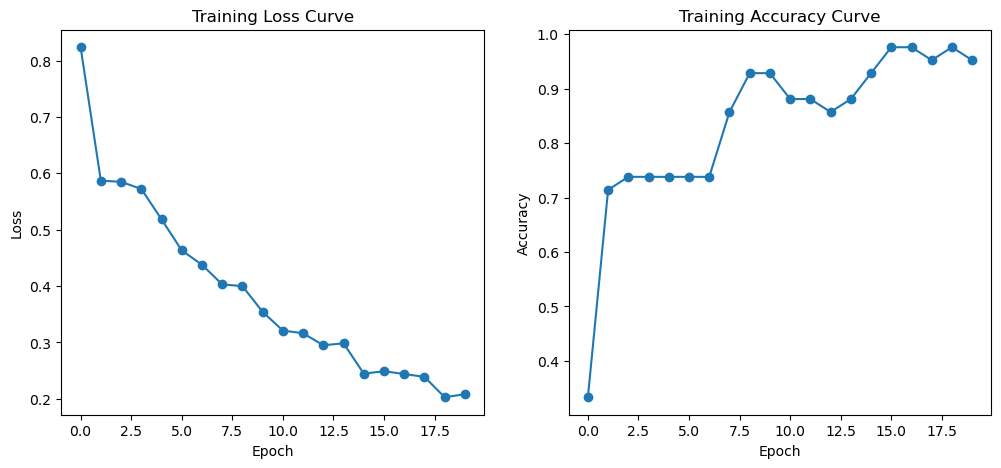

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from utils import LastLayer

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_dataloader= DataLoader(north_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pretrained ResNet18 model
resnet = models.resnet18(weights="IMAGENET1K_V1")

# Replace the final fully connected layer with our custom LastLayer
resnet.fc = LastLayer()
resnet = resnet.to(device)

# Freeze all parameters except the ones in the final layer
for name, param in resnet.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

# Define loss function and optimizer (only for last layer parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)

# Lists to store training loss and accuracy for each epoch
num_epochs = 20
train_losses = []
train_accuracies = []

# Training loop
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in training_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Plotting the training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

plt.subplot(1,2,2)
plt.plot(train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.show()

# Save only the last layer's weights
torch.save(resnet.fc.state_dict(), "last_layer_finetune.pth")

In [8]:
torch.save(resnet.fc.state_dict(), "lastlayer.pth")

In [9]:
from utils import LastLayer

resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()  # !  Important : No argument
fc.load_state_dict(torch.load("lastlayer.pth", weights_only=True))
resnet.fc = fc
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Question 4 :
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

<div class="alert alert-info">  LoRA stands for low rank approximation, and is described in https://arxiv.org/pdf/2106.09685.  </div>.

A linear layer $h = Wx$ with $W \in \mathbb{R}^{d \times k}$ is first decomposed in $W = W_0x + \Delta Wx$ where $W_0$ is frozen during training, and gradients flow through $\Delta W$ only. Then we pose $\Delta W = BA$ with $B \in \mathbb{R}^{d \times k}, A \in \mathbb{R}^{r \times k}$ and the rank $r$ verifies $r \ll \text{min}(d,k)$

In [10]:
import torch.nn as nn

class LoRAConv2d(nn.Module):
    def __init__(self, conv_layer: nn.Conv2d, r: int = 4):
        super(LoRAConv2d, self).__init__()
        # Freeze the original convolution weights.
        self.conv = conv_layer
        self.conv.weight.requires_grad = False

        # Use the same stride as the original conv layer so that the spatial dimensions match.
        self.lora_down = nn.Conv2d(
            conv_layer.in_channels, r, kernel_size=1, stride=conv_layer.stride, bias=False
        )
        self.lora_up = nn.Conv2d(
            r, conv_layer.out_channels, kernel_size=1, stride=1, bias=False
        )
        # Initialize the up projection to zeros so that initially the module behaves like the original conv.
        nn.init.zeros_(self.lora_up.weight)

    def forward(self, x):
        # The original conv output and the LoRA branch output now have matching spatial dimensions.
        return self.conv(x) + self.lora_up(self.lora_down(x))

Epoch 1/20, Loss: 0.7322, Accuracy: 0.5238
Epoch 2/20, Loss: 0.6142, Accuracy: 0.7381
Epoch 3/20, Loss: 0.5025, Accuracy: 0.7381
Epoch 4/20, Loss: 0.3541, Accuracy: 0.8333
Epoch 5/20, Loss: 0.3211, Accuracy: 0.9524
Epoch 6/20, Loss: 0.2974, Accuracy: 0.9524
Epoch 7/20, Loss: 0.2236, Accuracy: 1.0000
Epoch 8/20, Loss: 0.1720, Accuracy: 1.0000
Epoch 9/20, Loss: 0.1640, Accuracy: 0.9524
Epoch 10/20, Loss: 0.1010, Accuracy: 1.0000
Epoch 11/20, Loss: 0.1010, Accuracy: 0.9762
Epoch 12/20, Loss: 0.0506, Accuracy: 1.0000
Epoch 13/20, Loss: 0.0412, Accuracy: 1.0000
Epoch 14/20, Loss: 0.0316, Accuracy: 1.0000
Epoch 15/20, Loss: 0.0246, Accuracy: 1.0000
Epoch 16/20, Loss: 0.0191, Accuracy: 1.0000
Epoch 17/20, Loss: 0.0189, Accuracy: 1.0000
Epoch 18/20, Loss: 0.0235, Accuracy: 1.0000
Epoch 19/20, Loss: 0.0089, Accuracy: 1.0000
Epoch 20/20, Loss: 0.0079, Accuracy: 1.0000


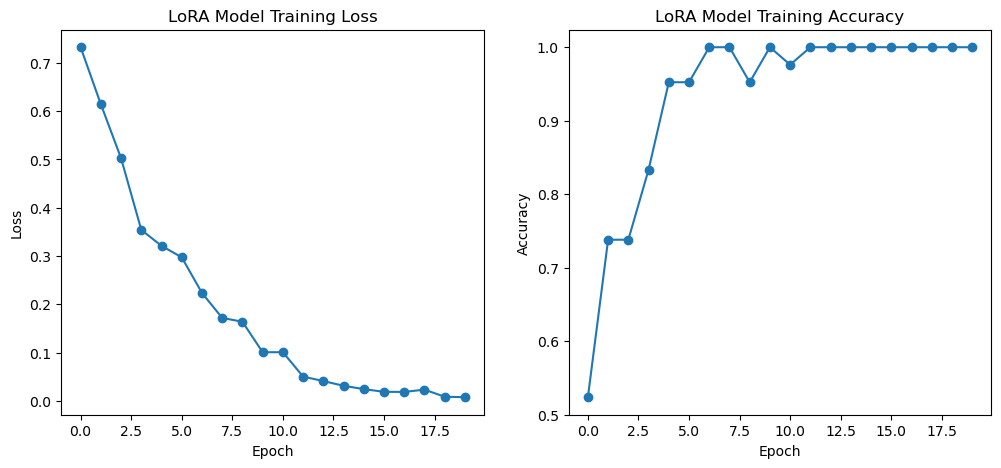

In [11]:
import torchvision.models as models

def apply_lora(model: nn.Module, r: int = 4):
    for name, module in list(model.named_children()):
        if isinstance(module, nn.Conv2d):
            setattr(model, name, LoRAConv2d(module, r=r))
        else:
            # Recursively apply LoRA to submodules.
            apply_lora(module, r=r)
    return model

# Create your model and apply LoRA
lora_model = models.resnet18(weights="DEFAULT")
lora_model.fc = LastLayer()  # use your custom last layer if needed
lora_model = apply_lora(lora_model, r=4).to(device)

# # Define training data augmentation/transforms.
# train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])

# At this point, only the parameters of the LoRA adapters (lora_down and lora_up) and any unfrozen parts (e.g., fc) have requires_grad=True.
# Create an optimizer that only updates the trainable parameters.
optimizer = optim.Adam(filter(lambda p: p.requires_grad, lora_model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop settings
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    lora_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in training_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = lora_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LoRA Model Training Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LoRA Model Training Accuracy')
plt.show()

# Save the LoRA model state dictionary
torch.save(lora_model.state_dict(), "lora_resnet.pth")

In [12]:
torch.save(lora_model.state_dict(), "lora_resnet.pth")

## Question 5 :
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`.


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (  !  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

In [13]:
## Data Augmentation
from torchvision.transforms import v2

# Define the data augmentation/transforms pipeline
tsfm = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(45),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

# apply the transforms to the dataset
transformed_north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=tsfm
)

# Create a DataLoader for the transformed dataset
transformed_dataloader = DataLoader(transformed_north_dataset, batch_size=32, shuffle=True)

/home/benjamin.deporte/.conda/envs/torchy/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [14]:
# We apply LoRA to get a new low-rank model
lora_model = models.resnet18(weights="DEFAULT")
lora_model.fc = LastLayer()  # use your custom last layer if needed
lora_model = apply_lora(lora_model, r=4).to(device)

assert isinstance(lora_model, models.ResNet)

Epoch 1/20, Loss: 0.6896, Accuracy: 0.6905
Epoch 2/20, Loss: 0.4985, Accuracy: 0.7381
Epoch 3/20, Loss: 0.3658, Accuracy: 0.7857
Epoch 4/20, Loss: 0.2924, Accuracy: 0.9524
Epoch 5/20, Loss: 0.2458, Accuracy: 0.9524
Epoch 6/20, Loss: 0.1871, Accuracy: 0.9762
Epoch 7/20, Loss: 0.1373, Accuracy: 0.9762
Epoch 8/20, Loss: 0.0988, Accuracy: 1.0000
Epoch 9/20, Loss: 0.0870, Accuracy: 1.0000
Epoch 10/20, Loss: 0.0590, Accuracy: 1.0000
Epoch 11/20, Loss: 0.0397, Accuracy: 1.0000
Epoch 12/20, Loss: 0.0375, Accuracy: 1.0000
Epoch 13/20, Loss: 0.0223, Accuracy: 1.0000
Epoch 14/20, Loss: 0.0234, Accuracy: 1.0000
Epoch 15/20, Loss: 0.0274, Accuracy: 1.0000
Epoch 16/20, Loss: 0.0081, Accuracy: 1.0000
Epoch 17/20, Loss: 0.0110, Accuracy: 1.0000
Epoch 18/20, Loss: 0.0056, Accuracy: 1.0000
Epoch 19/20, Loss: 0.0082, Accuracy: 1.0000
Epoch 20/20, Loss: 0.0054, Accuracy: 1.0000


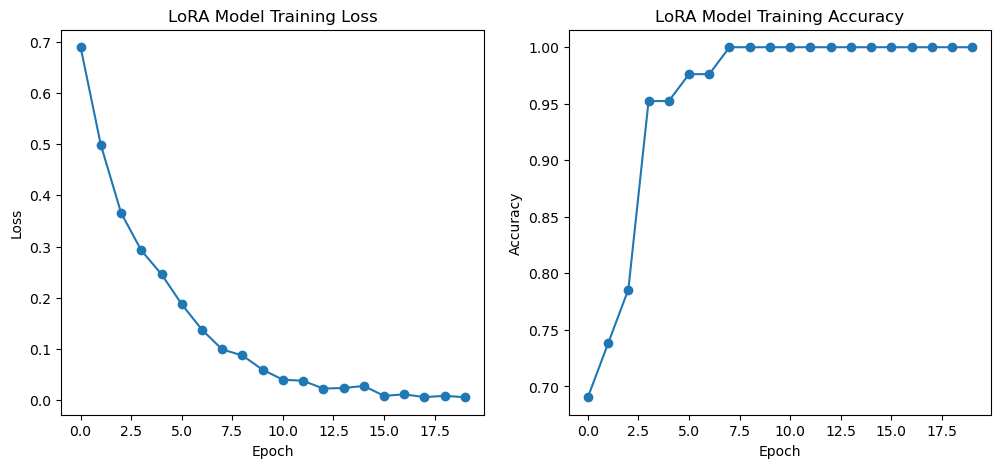

In [15]:
# At this point, only the parameters of the LoRA adapters (lora_down and lora_up) and any unfrozen parts (e.g., fc) have requires_grad=True.
# Create an optimizer that only updates the trainable parameters.
optimizer = optim.Adam(filter(lambda p: p.requires_grad, lora_model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop settings
num_epochs = 20
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    lora_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in training_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = lora_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LoRA Model Training Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LoRA Model Training Accuracy')
plt.show()

In [16]:
torch.save(lora_model.state_dict(), "daug_resnet.pth")

## Question 6 : (BONUS)
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file.